# Preprocess the Model for Ratio Reconstruction

### TO DO:
Have some simple tests that check data when loading. Leverage existing reading tools but add project specific checks later
* station data
* ensemble mean
* mask?

In [39]:
from climpyrical.datacube import read_data
from climpyrical.gridding import regrid_ensemble, extend_north

import xarray as xr
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

import matplotlib.pyplot as plt

In [40]:
# Path to the ensemble mean
# PATH_MEAN = '/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
# PATH_MEAN = '/home/nannau/nrc_data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
PATH_MEAN = '/home/nannau/nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
# dv = 'Rain-RL50'    
dv ='snw'
# dv='heating_degree_days_per_time_period'

ds_mean = xr.open_dataset(PATH_MEAN)

if 'time' in ds_mean.keys():
    ds_mean = ds_mean.squeeze('time')
    ds_mean = ds_mean.drop('time')


## Interpolate the model

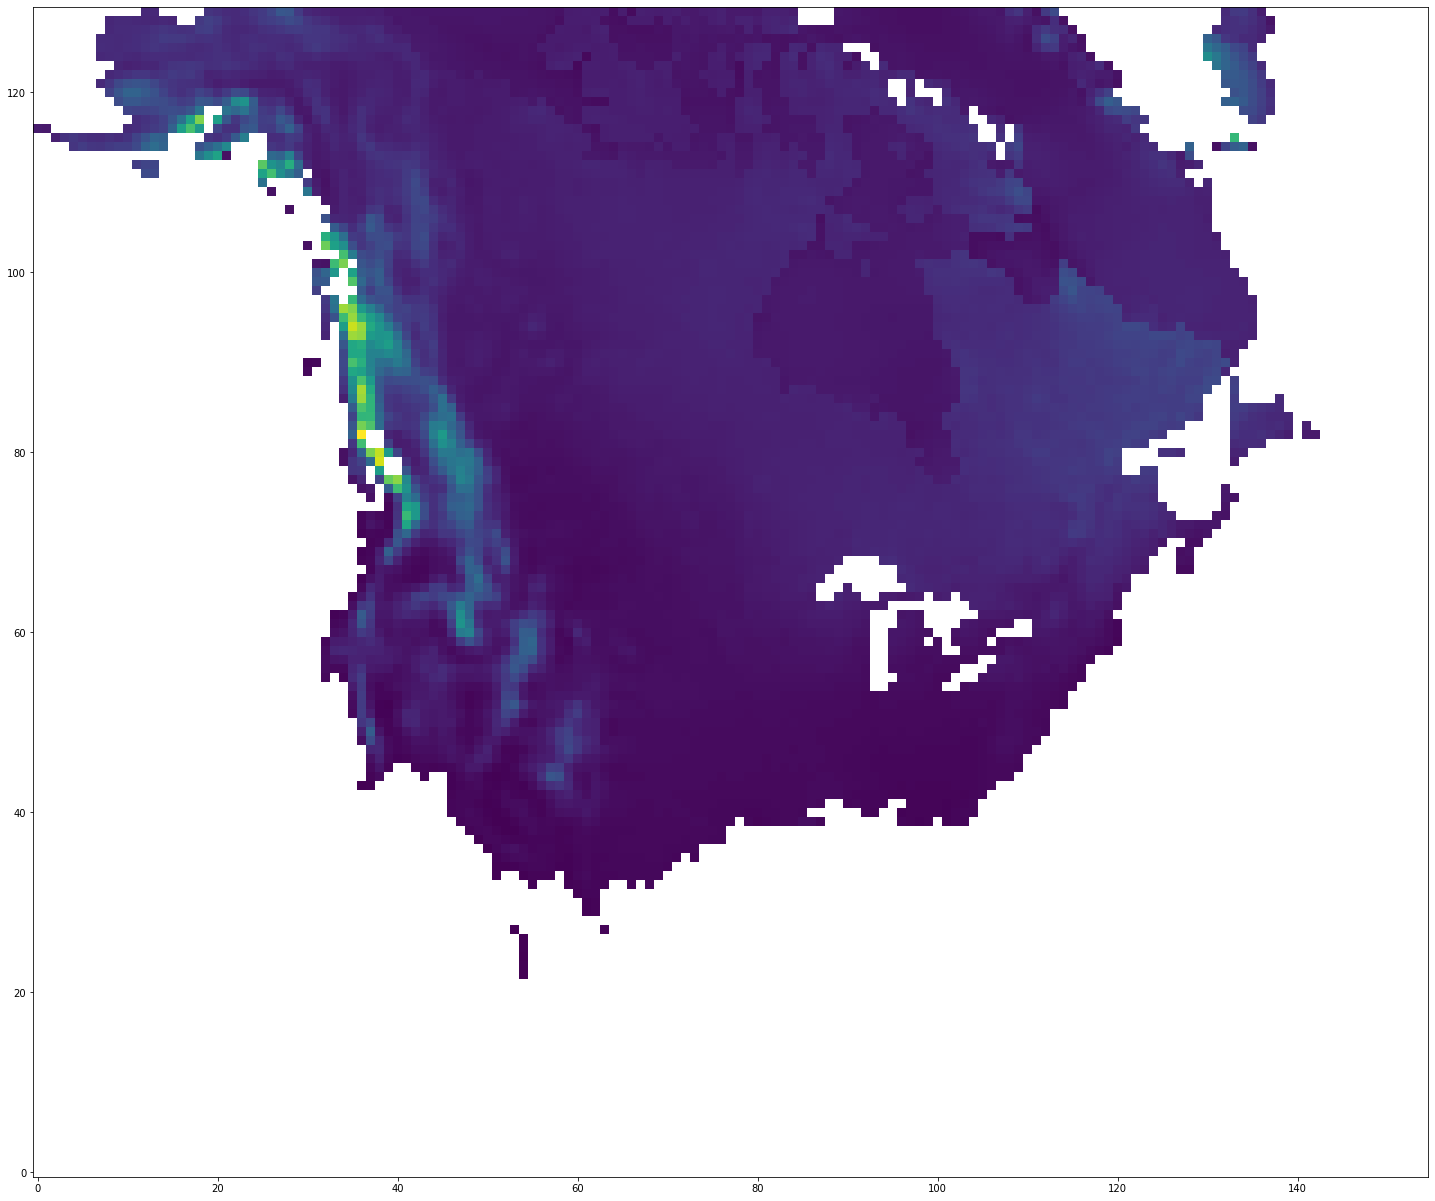

In [41]:
# Create coordinate grids 
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)
# Create array of mean
mean = ds_mean[dv]

plt.figure(figsize=(25, 25))
plt.imshow(ds_mean[dv], origin='lower')

Load the Surface to Land Fraction Mask `sftlf`

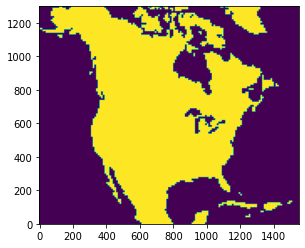

In [42]:
mask = read_data('/home/nannau/nrc_data/land_mask_CanRCM4_sftlf.nc', 'sftlf', keys=['rlat', 'rlon'])

# Drop unnecessary time dimension
if 'time' in mask.keys():
    mask = mask.squeeze('time')
#     mask = mask.drop('time')

mask = regrid_ensemble(mask, 'sftlf', 10, ['rlon', 'rlat'], copy=True)

# convert to boolean mask
mask = mask['sftlf'] >= 1.0

# Show mask
plt.imshow(mask, origin='lower')

Use regridded mask to reference the new coordinates on the map

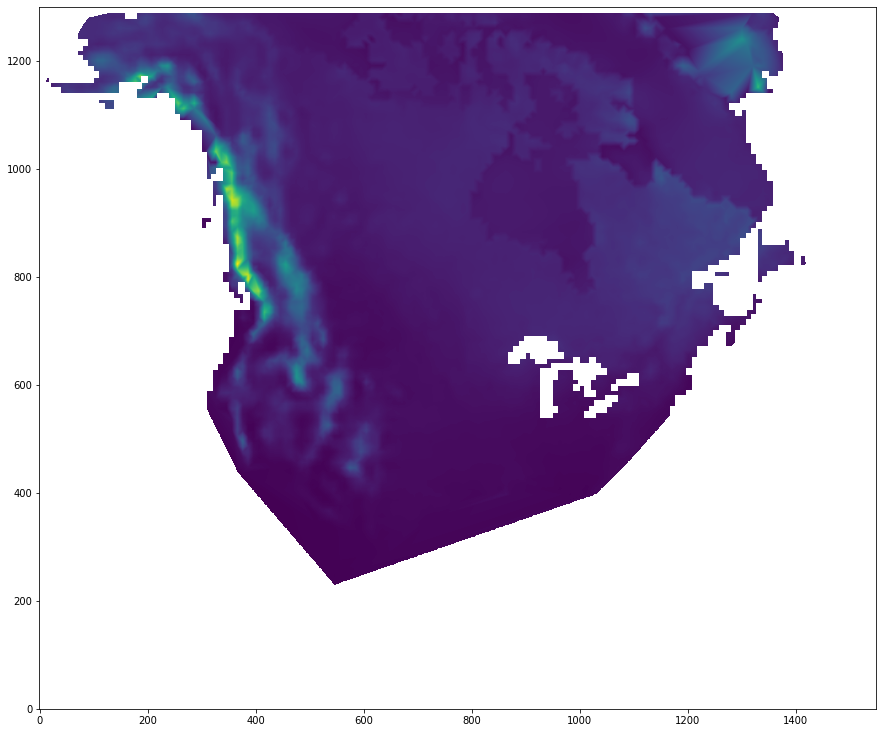

In [43]:
temp_field = np.ones(mask.shape)*np.nan

ds10_cp = regrid_ensemble(ds_mean, dv, 10, copy=True, keys=['rlat', 'rlon'])
nanmask10 = ~np.isnan(ds10_cp[dv]).values

interp_mask = np.logical_or(nanmask10, mask)

# find NaN values in ensemble mean
nanmask = ~np.isnan(mean)
# create interpolator for non NaN values
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
f = LinearNDInterpolator(points, mean.values[nanmask])
# new coordinates to interpolate to
nrlon, nrlat = np.meshgrid(mask.rlon.values, mask.rlat.values)

temp_field[interp_mask] = f(np.stack([nrlon[interp_mask], nrlat[interp_mask]]).T).T

ds_mean10 = xr.Dataset(
    {dv: (["rlat", "rlon"], temp_field)},
    coords={"rlon": ("rlon", mask.rlon), "rlat": ("rlat", mask.rlat)},
)

plt.figure(figsize=(15, 15))
plt.imshow(ds_mean10[dv], origin='lower')

Extend to the north for non-modelled region

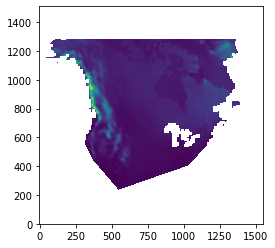

In [44]:
mean10_ext = extend_north(ds_mean10, dv, 210, fill_val=np.nan)
nrlon, nrlat = np.meshgrid(mean10_ext.rlon.values, mean10_ext.rlat.values)

plt.imshow(mean10_ext[dv], origin='lower')

Load final refined mask. If not accessible, or desire difference shapefile, follow `mask.ipynb`

(1510, 1550)


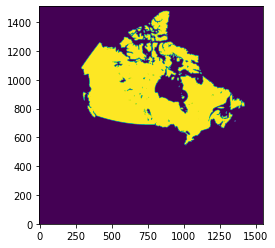

In [45]:
with xr.open_dataset('./data/processed/canada_mask_rp.nc') as ds:
    print(ds['mask'].shape)
    rmask = ds['mask'].values
    
plt.imshow(rmask, origin='lower')

Find inconsistent areas between the refined mask and the model by comparing model values with refined mask values

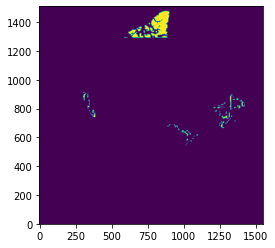

In [46]:
nanmask10 = ~np.isnan(mean10_ext[dv])
rmask_or = ~np.logical_or(~rmask, nanmask10)

plt.imshow(rmask_or, origin='lower')

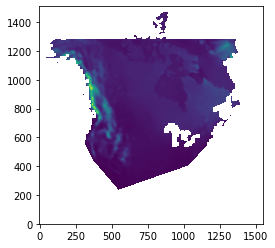

In [47]:
# Fill inconsistent points using closest neighbour.
# Not that the northern section will be filled later on

temp_field = mean10_ext[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
f = NearestNDInterpolator(points, mean10_ext[dv].values[nanmask10])
temp_field[rmask_or] = f(np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T)

mean10_ext_f = xr.Dataset(
    {dv: (["rlat", "rlon"], temp_field)},
    coords={"rlon": ("rlon", mean10_ext.rlon), "rlat": ("rlat", mean10_ext.rlat)},
)

plt.imshow(mean10_ext_f[dv], origin='lower')

In [48]:
np.any(mean10_ext_f[dv] < 0)

<xarray.DataArray 'snw' ()>
array(False)

In [49]:
# Check all inconsistencies are filled
assert ~np.any(~np.logical_or(~rmask, ~np.isnan(mean10_ext_f[dv]))).values

In [50]:
# with open('./data/processed/pre_processed.nc', 'wb') as d:
import os
if os.path.exists("./data/processed/pre_processed.nc"):
    os.remove("./data/processed/pre_processed.nc")

mean10_ext_f.to_netcdf('./data/processed/pre_processed.nc', 'w')

In [51]:
mean10_ext_f

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    snw      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan